<a href="https://colab.research.google.com/github/michaelmml/Summarisation-with-Transformers/blob/main/SummTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import os
import gc
import time
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from google.colab import drive
drive.mount("/content/drive")

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

BATCH_SIZE = 64 
EPOCHS = 10 

# Global parameters
root_folder='/content/drive/My Drive/Summarisationv2'
DATA_PATH = os.path.abspath(os.path.join(root_folder))
train_path = DATA_PATH

Mounted at /content/drive


In [ ]:
df = pd.read_csv(DATA_PATH+"/financialnewssum2022.csv")

Filter text and summary lengths as desired for model training parameters.

In [ ]:
df = df[df['summary'].apply(lambda x: len(x.split()) >= 7)]

In [ ]:
cleaned_text = np.array(df['text'])
cleaned_summary = np.array(df['summary'])

for i in range(len(cleaned_text)):
    if len(cleaned_text[i].split()) > 30:
        cleaned_text[i] = ' '.join(cleaned_text[i].split()[:30])

for i in range(len(cleaned_summary)):
    if len(cleaned_summary[i].split()) > 15:
        cleaned_summary[i] = ' '.join(cleaned_summary[i].split()[:15])

df = pd.DataFrame({'text': cleaned_text, 'summary': cleaned_summary})

In [ ]:
def subword_tokenize(corpus, vocab_size, max_length):
  # Create the vocabulary using Subword tokenization
  tokenizer_corpus = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus, target_vocab_size=vocab_size)
  # Get the final vocab size, adding the eos and sos tokens
  num_words = tokenizer_corpus.vocab_size + 2
  # Set eos and sos token
  sos_token = [num_words-2]
  eos_token = [num_words-1]
  # Tokenize the corpus
  sentences = [sos_token + tokenizer_corpus.encode(sentence) + eos_token
          for sentence in corpus]
  # Identify the index of the sentences longer than max length
  idx_to_remove = [count for count, sent in enumerate(sentences)
                 if len(sent) > max_length]
  #Pad the sentences
  sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=max_length)
  
  return sentences, tokenizer_corpus, num_words, sos_token, eos_token, idx_to_remove

In [ ]:
MAX_VOCAB_SIZE = 2**14
MAX_LENGTH_text = 50
MAX_LENGTH_sum = 20

# Tokenize and pad the input sequences
encoder_inputs, tokenizer_inputs, num_words_inputs, sos_token_input, eos_token_input, del_idx_inputs = subword_tokenize(np.array(df['text']), 
                                                                                                        MAX_VOCAB_SIZE, MAX_LENGTH_text)
# Tokenize and pad the outputs sequences
decoder_outputs, tokenizer_outputs, num_words_output, sos_token_output, eos_token_output, del_idx_outputs = subword_tokenize(np.array(df['summary']), 
                                                                                                        MAX_VOCAB_SIZE, MAX_LENGTH_sum)

In [ ]:
import pickle

# saving
with open(DATA_PATH+"/in_tokenizer.pickle", 'wb') as handle:
    pickle.dump(tokenizer_inputs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# saving
with open(DATA_PATH+"/out_tokenizer.pickle", 'wb') as handle:
    pickle.dump(tokenizer_outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
num_words_inputs, sos_token_input, eos_token_input, num_words_output, sos_token_output, eos_token_output

(16910, [16908], [16909], 17175, [17173], [17174])

num_words_inputs = 16910;
sos_token_input = [16908];
eos_token_input = [16909];
num_words_output = 17175;
sos_token_output = [17173];
eos_token_output = [17174];

In [ ]:
# Check the tokenize function
print(encoder_inputs[:5], sos_token_input, eos_token_input, del_idx_inputs)
print(decoder_outputs[:5], sos_token_output, eos_token_output, del_idx_outputs)
num_words_inputs, num_words_output

[[16908    23     1  7341 12686   128 11190     1  4160 15410    17     2
      1 11873   916 16033    17 16065    50    52 13489 16684   144    12
   2306     2   446  1366  5837  1161  2098  2943  5680   202  7638 16909
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [16908  9023    14  4091     1 13850   281  1953     1  7344 13539  9023
      1   183  6325  5654   752  9023 10811    45     1  4594 11940   243
   9023  7672 10199   763  5229  8927   449  2592 12107  1545     1  1234
   7751  2961 10423 16909     0     0     0     0     0     0     0     0
      0     0]
 [16908   574  1724   897  1441    37     7     4  6724     1    13    81
     22   466   172 13628  1299   653     1  1200  7649  7156  9490    27
      1  6136  5808   963 15017 16684 15126  7001     2  1037  1959  4504
  12963  6039 16909     0     0     0     0     0     0     0     0     0
      0     0]
 [16908    22   551   185   434  1339  2586    32 10148 16684   372

(16910, 17175)

In [ ]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_outputs))
dataset = dataset.shuffle(len(np.array(df['text'])), reshuffle_each_iteration=True).batch(
    BATCH_SIZE, drop_remainder=True)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

Tensors are generalizations of scalars (that have no indices), vectors (that have exactly one index), and matrices (that have exactly two indices) to an arbitrary number of indices.

In [ ]:
def scaled_dot_product_attention(q,k,v,mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  # Cast tensor to new type; x = tf.constant([1.8, 2.2], dtype=tf.float32); tf.cast(x, tf.int32) => Tensor shape(2,), dtype=int32, numpy=array([1,2], dtype=int32)

  scaled_attention = matmul_qk / tf.math.sqrt(dk)
  # add the mask
  if mask is not None:
    scaled_attention += (mask * -1e9)
  
  attention_weights = tf.nn.softmax(scaled_attention, axis=-1)
  output = tf.matmul(attention_weights, v)

  return output, attention_weights

Example set of query, keys and value and resulting scaled dot product attention.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0,2,1,3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

The positional encoding vector is added to the embedding vector.
But the embeddings do not encode the relative position of tokens in a sentence. So after adding the positional encoding, tokens will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

In [ ]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model): # pos: (seq_length, 1) i: (1, d_model)
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles

    def call(self, inputs):
        # input shape batch_size, seq_length, d_model
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        # Calculate the positional encodings
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        # Expand the encodings with a new dimension using np.newaxis
        pos_encoding = angles[np.newaxis, ...]
        
        return tf.cast(pos_encoding, tf.float32) + inputs

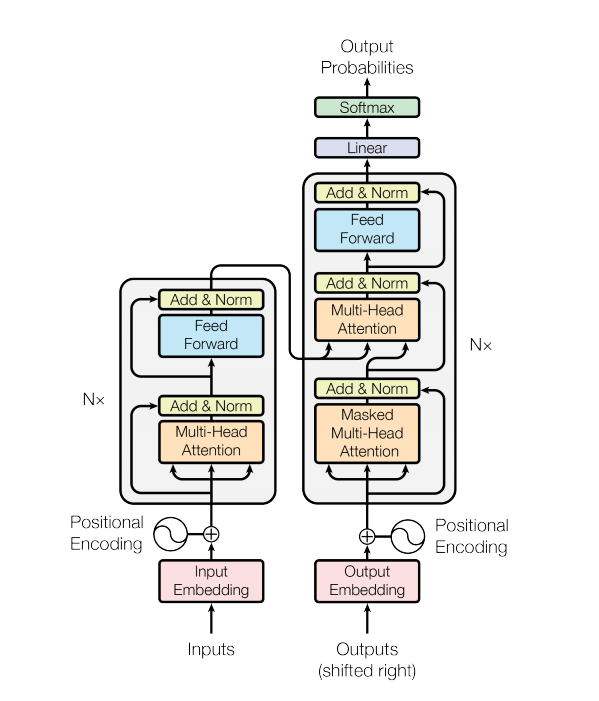

In [ ]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, d_model, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.n_heads = n_heads
        self.d_model = d_model
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.d_model, self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        # Layer Normalization
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        # Fully connected feed forward layer
        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        # Layer normalization
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        # Forward pass of the multi-head attention
        attention, _ = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        # Call to the residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call to the FC layer
        outputs = self.ffn1_relu(attention)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        # Call to residual connection and the layer normalization
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [ ]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(d_model, FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        return outputs

In [ ]:
class DecoderLayer(layers.Layer):
    
    def __init__(self, d_model, FFN_units, n_heads, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.FFN_units = FFN_units
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        # self.d_model = input_shape[-1]
        # Self multi head attention, causal attention
        self.multi_head_causal_attention = MultiHeadAttention(self.d_model, self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        # Multi head attention, encoder-decoder attention 
        self.multi_head_enc_dec_attention = MultiHeadAttention(self.d_model, self.n_heads)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed foward
        self.ffn1_relu = layers.Dense(units=self.FFN_units,
                                    activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Call the masked self-attention
        attention, attn_weights_block1 = self.multi_head_causal_attention(inputs,
                                                inputs,
                                                inputs,
                                                mask_1)
        attention = self.dropout_1(attention, training)
        # Residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call the encoder-decoder attention
        attention_2, attn_weights_block2 = self.multi_head_enc_dec_attention(enc_outputs,
                                                  enc_outputs,
                                                  attention,
                                                  mask_2)
        attention_2 = self.dropout_2(attention_2, training)
        # Residual connection and layer normalization
        attention_2 = self.norm_2(attention_2 + attention)
        # Call the Feed forward
        outputs = self.ffn1_relu(attention_2)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_3(outputs, training)
        # Residual connection and layer normalization
        outputs = self.norm_3(outputs + attention_2)
        
        return outputs, attn_weights_block1, attn_weights_block2

In [ ]:
class Decoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.n_layers = n_layers
        # Embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stacked layers of multi-head attention and feed forward
        self.dec_layers = [DecoderLayer(d_model, FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        attention_weights = {}
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs, block1, block2 = self.dec_layers[i](outputs,
                                         enc_outputs,
                                         mask_1,
                                         mask_2,
                                         training)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
        
        return outputs, attention_weights

In [ ]:
def create_padding_mask(seq):
  mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] 

def create_look_ahead_mask(seq):
  seq_len = tf.shape(seq)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  return look_ahead_mask

In [ ]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        # Build the encoder
        self.encoder = Encoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_enc,
                               d_model)
        # Build the decoder
        self.decoder = Decoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_dec,
                               d_model)
        # build the linear transformation and softmax function
        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def call(self, enc_inputs, dec_inputs, training):
        # Create the padding mask for the encoder
        enc_mask = create_padding_mask(enc_inputs)
        # Create the mask for the causal attention
        dec_mask_1 = tf.maximum(
            create_padding_mask(dec_inputs),
            create_look_ahead_mask(dec_inputs)
        )
        # Create the mask for the encoder-decoder attention
        dec_mask_2 = create_padding_mask(enc_inputs)
        # Call the encoder
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        # Call the decoder
        dec_outputs, attention_weights = self.decoder(dec_inputs,
                                   enc_outputs,
                                   dec_mask_1,
                                   dec_mask_2,
                                   training)
        # Call the Linear and Softmax functions
        outputs = self.last_linear(dec_outputs)
        
        return outputs, attention_weights

In [ ]:
def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
def main_train(dataset, transformer, n_epochs, print_every=50):
  ''' Train the transformer model for n_epochs using the data generator dataset'''
  losses = []
  accuracies = []
  # In every epoch
  for epoch in range(n_epochs):
    print("Starting epoch {}".format(epoch+1))
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    # Get a batch of inputs and targets
    for (batch, (enc_inputs, targets)) in enumerate(dataset):
        # Set the decoder inputs
        dec_inputs = targets[:, :-1]
        # Set the target outputs, right shifted
        dec_outputs_real = targets[:, 1:]
        with tf.GradientTape() as tape:
            # Call the transformer and get the predicted output
            predictions, _ = transformer(enc_inputs, dec_inputs, True)
            # Calculate the loss
            loss = loss_function(dec_outputs_real, predictions)
        # Update the weights and optimizer
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        # Save and store the metrics
        train_loss(loss)
        train_accuracy(dec_outputs_real, predictions)
        
        if batch % print_every == 0:
            losses.append(train_loss.result())
            accuracies.append(train_accuracy.result())
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))
            
    # Checkpoint the model on every epoch        
    ckpt_save_path = ckpt_manager.save()
    print("Saving checkpoint for epoch {} in {}".format(epoch+1,
                                                        ckpt_save_path))
    print("Time for 1 epoch: {} secs\n".format(time.time() - start))

  return losses, accuracies

In [ ]:
# Set hyperparamters for the model
D_MODEL = 512 # 512
N_LAYERS = 4 # 6
FFN_UNITS = 512 # 2048
N_HEADS = 8 # 8
DROPOUT_RATE = 0.1 # 0.1

In [ ]:
# Clean the session
tf.keras.backend.clear_session()
# Create the Transformer model
transformer = Transformer(vocab_size_enc=num_words_inputs,
                          vocab_size_dec=num_words_output,
                          d_model=D_MODEL,
                          n_layers=N_LAYERS,
                          FFN_units=FFN_UNITS,
                          n_heads=N_HEADS,
                          dropout_rate=DROPOUT_RATE)

# Define a categorical cross entropy loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")
# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(D_MODEL)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
import pickle

with open(DATA_PATH+"/in_tokenizer.pickle", 'rb') as handle:
    tokenizer_inputs = pickle.load(handle)

with open(DATA_PATH+"/out_tokenizer.pickle", 'rb') as handle:
    tokenizer_outputs = pickle.load(handle)

In [ ]:
num_words_inputs = 16910
sos_token_input = [16908]
eos_token_input = [16909]
num_words_output = 17175
sos_token_output = [17173]
eos_token_output = [17174]

In [ ]:
#Create the Checkpoint 
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, DATA_PATH, max_to_keep=2)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Last checkpoint restored.")

Last checkpoint restored.


In [ ]:
# Train the model
losses, accuracies = main_train(dataset, transformer, 5, 100)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.1211 Accuracy 0.6003
Epoch 1 Batch 100 Loss 0.1203 Accuracy 0.5859
Saving checkpoint for epoch 1 in /content/drive/My Drive/Summarisationv2/ckpt-36
Time for 1 epoch: 126.97376608848572 secs

Starting epoch 2
Epoch 2 Batch 0 Loss 0.0960 Accuracy 0.5831
Epoch 2 Batch 100 Loss 0.1133 Accuracy 0.5863
Saving checkpoint for epoch 2 in /content/drive/My Drive/Summarisationv2/ckpt-37
Time for 1 epoch: 56.11197638511658 secs

Starting epoch 3
Epoch 3 Batch 0 Loss 0.0942 Accuracy 0.5979
Epoch 3 Batch 100 Loss 0.1030 Accuracy 0.5896
Saving checkpoint for epoch 3 in /content/drive/My Drive/Summarisationv2/ckpt-38
Time for 1 epoch: 54.188207149505615 secs

Starting epoch 4
Epoch 4 Batch 0 Loss 0.0868 Accuracy 0.6069
Epoch 4 Batch 100 Loss 0.0978 Accuracy 0.5897
Saving checkpoint for epoch 4 in /content/drive/My Drive/Summarisationv2/ckpt-39
Time for 1 epoch: 55.574565172195435 secs

Starting epoch 5
Epoch 5 Batch 0 Loss 0.0861 Accuracy 0.6094
Epoch 5 Batch 10

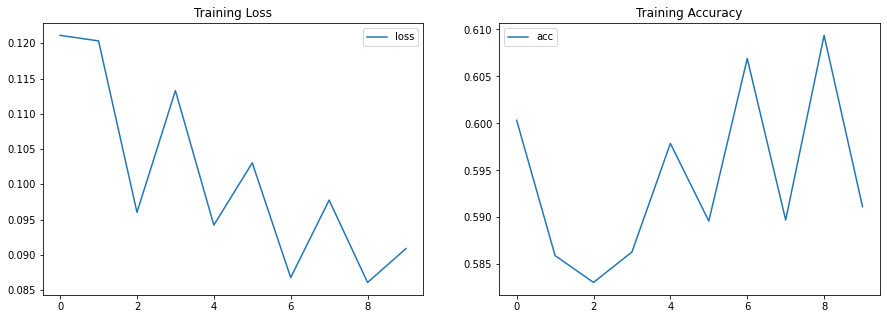

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [ ]:
class Summarising(tf.Module):
  def __init__(self, tokenizer_in, tokenizer_out, transformer):
    self.tokenizer_in = tokenizer_in
    self.tokenizer_out = tokenizer_out
    self.transformer = transformer

  def __call__(self, sentence, target_max_len=15):
    # Tokenize the input sequence using the tokenizer_in
    sentence = sos_token_input + self.tokenizer_in.encode(sentence) + eos_token_input
    enc_input = tf.expand_dims(sentence, axis=0)

    # Set the initial output sentence to sos
    out_sentence = sos_token_output
    output = tf.expand_dims(out_sentence, axis=0)

    # For max target len tokens
    for _ in range(target_max_len):
        # Call the transformer and get the logits 
        predictions, _ = self.transformer(enc_input, output, False)
        # Extract the logists of the next word
        prediction = predictions[:, -1:, :]
        # The highest probability is taken
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        # Check if it is the eos token
        if predicted_id == eos_token_output:
            return tf.squeeze(output, axis=0)
        # Concat the predicted word to the output sequence
        output = tf.concat([output, predicted_id], axis=-1)

    # _, attention_weights = transformer(enc_input, output, False)
    # output = tf.squeeze(output, axis=0)

    return output

**Model v35 is now saved - refer to Deployed version for streamlined code to import model, run summaries and generate attention weights.**

In [ ]:
tf.saved_model.save(transformer, export_dir=DATA_PATH+"/modelFINAL")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Summarisationv2/modelFINAL/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Summarisationv2/modelFINAL/assets


In [ ]:
reloadedtransformer = tf.saved_model.load(DATA_PATH+"/modelFINAL")

In [ ]:
summariser = Summarising(tokenizer_inputs, tokenizer_outputs, reloadedtransformer)

In [ ]:
def extract(output):
    tokens = output.numpy()
    sentence = tokenizer_outputs.decode(
        [i for i in tokens if i < sos_token_output])
    return sentence

In [ ]:
sentence = "congress often overreach but usually not the very first day house republicans the verge washington takeover the new congress convened tuesday could not stop themselves from trying dilute the power despised ethics watchdog their first order business the process"
summary_tok = summariser(sentence)

In [ ]:
extract(summary_tok)

'states no smart freedom of republicans do not move past tax returns says'

In [ ]:
input_sent = sos_token_input + tokenizer_inputs.encode(sentence) + eos_token_input
enc_input = tf.expand_dims(input_sent, axis=0)

In [ ]:
_, attention_weights = transformer(enc_input, tf.expand_dims(summary_tok, axis=0), False)

In [ ]:
attention_weights

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

In [ ]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([14, 34])

In [ ]:
def plot_attention_weights(sentence, summary_tok, attention_heads):
  in_tokens = tokenizer_inputs.encode(sentence)
  in_tokens = tf.expand_dims(in_tokens, axis=0)

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, summary_tok, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

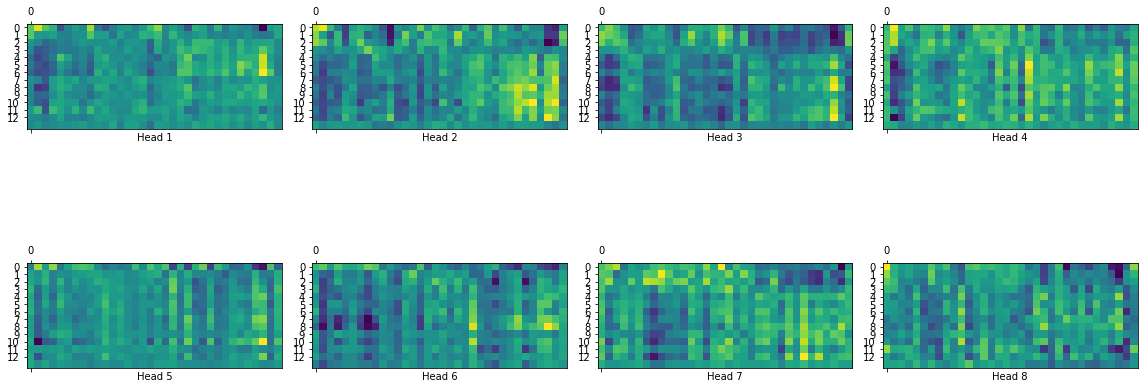

In [ ]:
plot_attention_weights(sentence, summary_tok,
                       attention_weights['decoder_layer4_block2'][0])